In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import scipy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d  

### Network build

In [3]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
ort10_coltar10 = pd.read_csv('ort10_coltar10_mean.csv', header=None).values
ort10_colfeat10 = pd.read_csv('ort10_colfeat10_mean.csv', header=None).values
ort20 = pd.read_csv('ort20_mean.csv', header=None).values
ort5_coltar10_colfeat5 = pd.read_csv('ort5_coltar10_colfeat5_mean.csv', header=None).values
ort5_coltar15 = pd.read_csv('ort5_coltar15_mean.csv', header=None).values
ort10_coltar5_colfeat5 = pd.read_csv('ort10_coltar5_colfeat5_mean.csv', header=None).values
ort5_colfeat15 = pd.read_csv('ort5_colfeat15_mean.csv', header=None).values
ort15_colfeat5 = pd.read_csv('ort15_colfeat5_mean.csv', header=None).values
ort5_coltar5_colfeat10 = pd.read_csv('ort5_coltar5_colfeat10_mean.csv', header=None).values

ort10_coltar10_data = pd.read_csv('ort10_coltar10_data.csv', header=None)
ort10_colfeat10_data = pd.read_csv('ort10_colfeat10_data.csv', header=None)
ort20_data = pd.read_csv('ort20_data.csv', header=None)
ort5_coltar10_colfeat5_data = pd.read_csv('ort5_coltar10_colfeat5_data.csv', header=None)
ort5_coltar15_data = pd.read_csv('ort5_coltar15_data.csv', header=None)
ort10_coltar5_colfeat5_data = pd.read_csv('ort10_coltar5_colfeat5_data.csv', header=None)
ort5_colfeat15_data = pd.read_csv('ort5_colfeat15_data.csv', header=None)
ort15_colfeat5_data = pd.read_csv('ort15_colfeat5_data.csv', header=None)
ort5_coltar5_colfeat10_data = pd.read_csv('ort5_coltar5_colfeat10_data.csv', header=None)

In [5]:
true_results = [
    ort10_coltar10,
    ort10_colfeat10,
    ort20,
    ort5_coltar10_colfeat5,
    ort5_coltar15,
    ort10_coltar5_colfeat5,
    ort5_colfeat15,
    ort15_colfeat5,
    # ort5_coltar5_colfeat10
]
verify_results = [
    ort5_coltar5_colfeat10
]

In [6]:
datasets = [
    ort10_coltar10_data,
    ort10_colfeat10_data,
    ort20_data,
    ort5_coltar10_colfeat5_data,
    ort5_coltar15_data,
    ort10_coltar5_colfeat5_data,
    ort5_colfeat15_data,
    ort15_colfeat5_data,
    # ort5_coltar5_colfeat10_data
]
verify_datasets = [
    ort5_coltar5_colfeat10_data
]

In [7]:
vifs = []

for j in range(len(datasets)):
    datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    vifs.append([])
    
    for k in range(50, len(datasets[j]), 50):
        features = "+".join(map(str, datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        vifs[j].append(vif)

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [8]:
verify_vifs = []

for j in range(len(verify_datasets)):
    verify_datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    verify_vifs.append([])
    
    for k in range(50, len(verify_datasets[j]), 50):
        features = "+".join(map(str, verify_datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        verify_vifs[j].append(vif)

In [9]:
class SSNet2D(nn.Module):
    def __init__(self, dim1=1, dim2=1, dim3=1):
        super().__init__()
        self.fc1 = nn.Linear(dim1, dim2)
        self.fc2 = nn.Linear(dim2, dim3)
        
        self.fc1.weight = nn.Parameter(Variable(torch.FloatTensor(np.ones((dim2, dim1))), requires_grad=True))
        self.fc1.bias = nn.Parameter(Variable(torch.FloatTensor(np.ones(dim2)), requires_grad=True))

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = torch.pow(x, -1)
        x = self.fc2(x)
        
        return x

In [10]:
net = SSNet2D(len(vifs[0][0]), len(true_results[0][:,-1]), len(true_results[0][:,-1]))
print(net)

data = [
    [vifs[i][j], true_results[i][:,-1]] 
    for i in range(len(datasets)) 
    for j in range(len(vifs[i]))
]

criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
#optimizer = optim.Adam(net.parameters(), lr=1e-3)

SSNet2D(
  (fc1): Linear(in_features=22, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=180, bias=True)
)


In [11]:
optimizer = optim.SGD(net.parameters(), lr=1)
for epoch in range(5001):
    full_loss = 0
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        X, Y = (Variable(torch.FloatTensor([X]), requires_grad=True), 
                Variable(torch.FloatTensor([Y]), requires_grad=False))
        
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        full_loss += loss.item()
        
    if (epoch % 100 == 0):
        print("Epoch {} - loss: {}, lr: {}".format(epoch, full_loss, optimizer.param_groups[0]['lr']))

Epoch 0 - loss: 38.57634761556983, lr: 1
Epoch 100 - loss: 0.7052893150830641, lr: 1
Epoch 200 - loss: 0.7053412430686876, lr: 1
Epoch 300 - loss: 0.7052754574397113, lr: 1
Epoch 400 - loss: 0.7051988380844705, lr: 1
Epoch 500 - loss: 0.7051078810472973, lr: 1
Epoch 600 - loss: 0.7049972841923591, lr: 1
Epoch 700 - loss: 0.7048609895864502, lr: 1
Epoch 800 - loss: 0.7046912889636587, lr: 1
Epoch 900 - loss: 0.7044786088226829, lr: 1
Epoch 1000 - loss: 0.7042107469460461, lr: 1
Epoch 1100 - loss: 0.7038727126200683, lr: 1
Epoch 1200 - loss: 0.7034449176862836, lr: 1
Epoch 1300 - loss: 0.7029026365198661, lr: 1
Epoch 1400 - loss: 0.7022144900693092, lr: 1
Epoch 1500 - loss: 0.7013401636795606, lr: 1
Epoch 1600 - loss: 0.7002279366133735, lr: 1
Epoch 1700 - loss: 0.6988110056845471, lr: 1
Epoch 1800 - loss: 0.6970028210780583, lr: 1
Epoch 1900 - loss: 0.6946903884818312, lr: 1
Epoch 2000 - loss: 0.6917243498610333, lr: 1
Epoch 2100 - loss: 0.6879051916475873, lr: 1
Epoch 2200 - loss: 0.68

In [13]:
PATH = 'net_saved.pth'
torch.save(net.state_dict(), PATH)

In [14]:
model = SSNet2D(len(vifs[0][0]), len(true_results[0][:,-1]), len(true_results[0][:,-1]))
model.load_state_dict(torch.load(PATH))
model.eval()

SSNet2D(
  (fc1): Linear(in_features=22, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=180, bias=True)
)

In [16]:
model(Variable(torch.FloatTensor([vifs[0][0]]), requires_grad=False))

tensor([[0.8608, 0.8259, 0.7348, 0.7374, 0.8554, 0.9236, 0.9377, 0.9466, 0.9510,
         0.9543, 0.9629, 0.9635, 0.9586, 0.9699, 0.9633, 0.9745, 0.9781, 0.9800,
         0.9797, 0.9820, 0.9810, 0.9842, 0.9789, 0.9803, 0.9796, 0.9803, 0.9792,
         0.9697, 0.9777, 0.9777, 0.9775, 0.9685, 0.9784, 0.9788, 0.9787, 0.9789,
         0.9790, 0.9799, 0.9808, 0.9804, 0.9806, 0.9701, 0.9696, 0.9685, 0.9689,
         0.9702, 0.9688, 0.9709, 0.9712, 0.9701, 0.9722, 0.9723, 0.9632, 0.9773,
         0.9757, 0.9737, 0.9731, 0.9739, 0.9746, 0.9750, 0.9724, 0.9539, 0.9555,
         0.9551, 0.9450, 0.9542, 0.9562, 0.9574, 0.9568, 0.9556, 0.9554, 0.9545,
         0.9553, 0.9558, 0.9560, 0.9562, 0.9550, 0.9546, 0.9535, 0.9543, 0.9537,
         0.9576, 0.9576, 0.9581, 0.9576, 0.9573, 0.9577, 0.9581, 0.9580, 0.9585,
         0.9584, 0.9595, 0.9551, 0.9444, 0.9527, 0.9551, 0.9548, 0.9549, 0.9551,
         0.9543, 0.9545, 0.9546, 0.9537, 0.9520, 0.9517, 0.9501, 0.9499, 0.9321,
         0.9320, 0.9316, 0.9

### Visualization

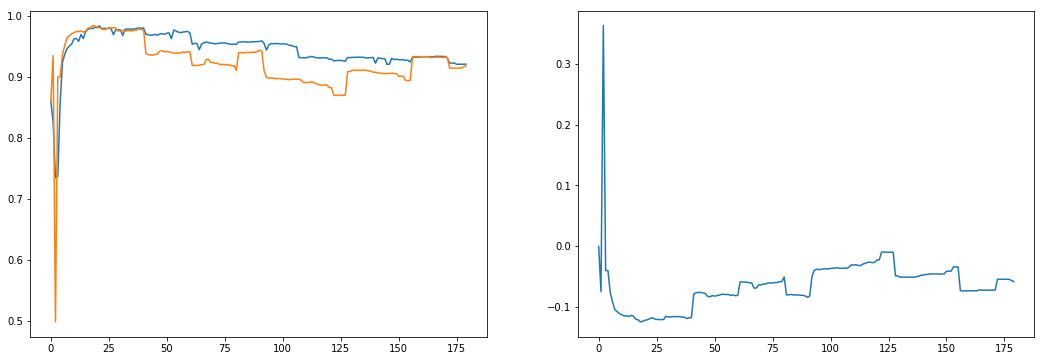

In [18]:
i = 0

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

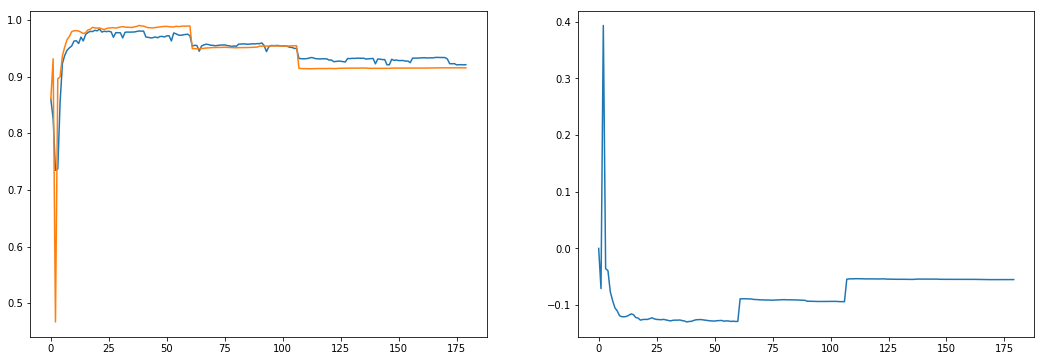

In [19]:
i = 1

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

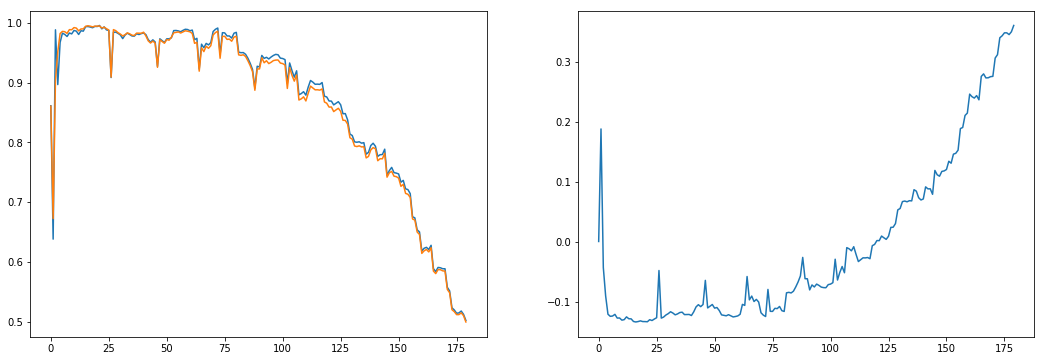

In [20]:
i = 3

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

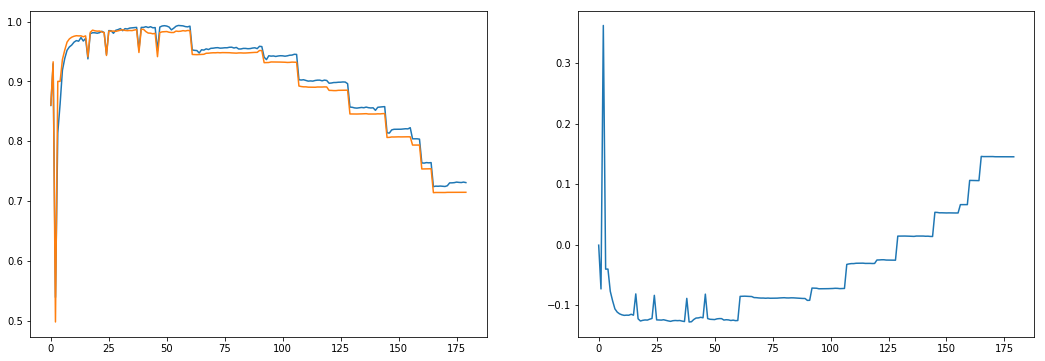

In [21]:
i = 5

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

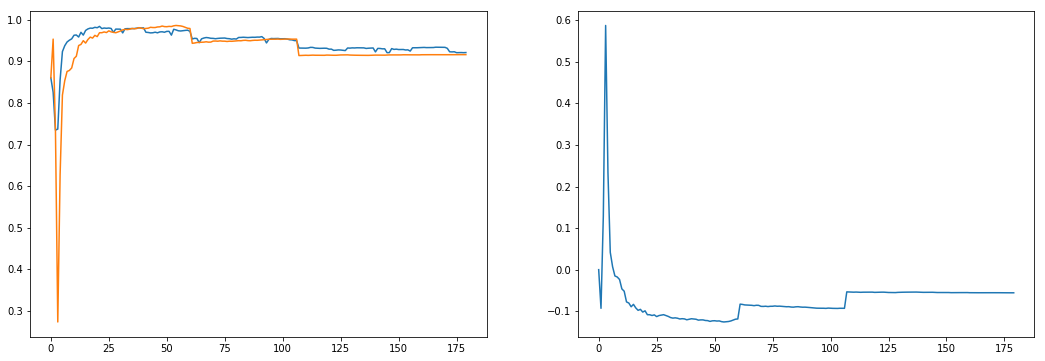

In [22]:
i = 7

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

---

In [23]:
i = 7

In [24]:
m_ = true_results[i][:, -1].argmax()

In [25]:
m_

54

Let's consider $m^* == 54$

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


/Users/xtonev/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


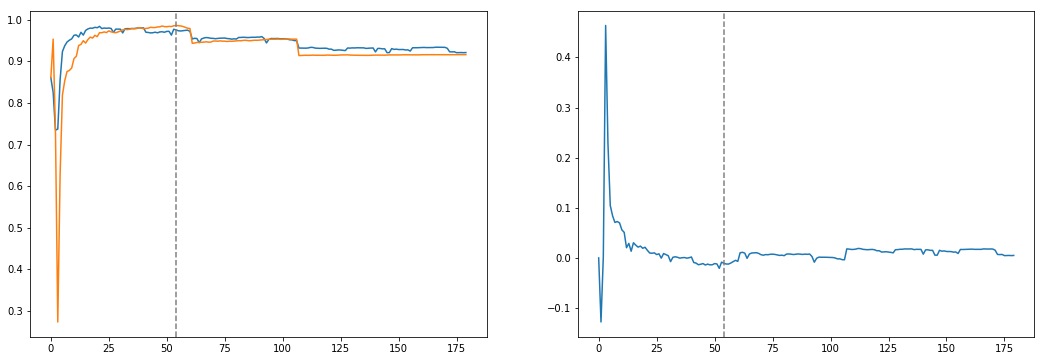

In [26]:
m = 5

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

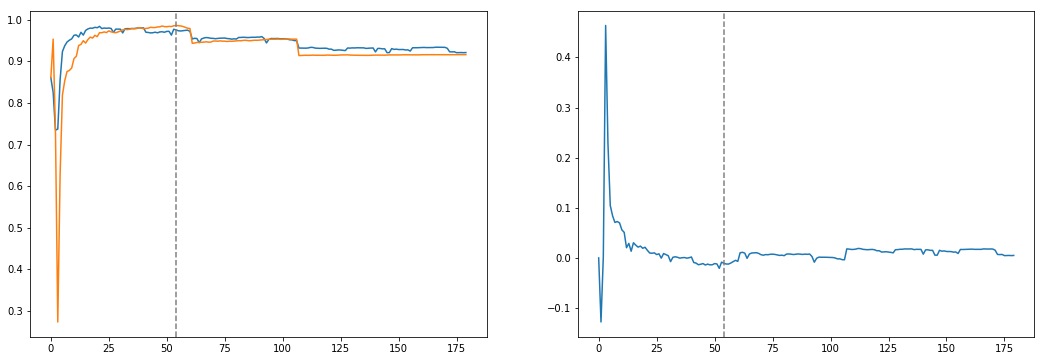

In [27]:
m = 15

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

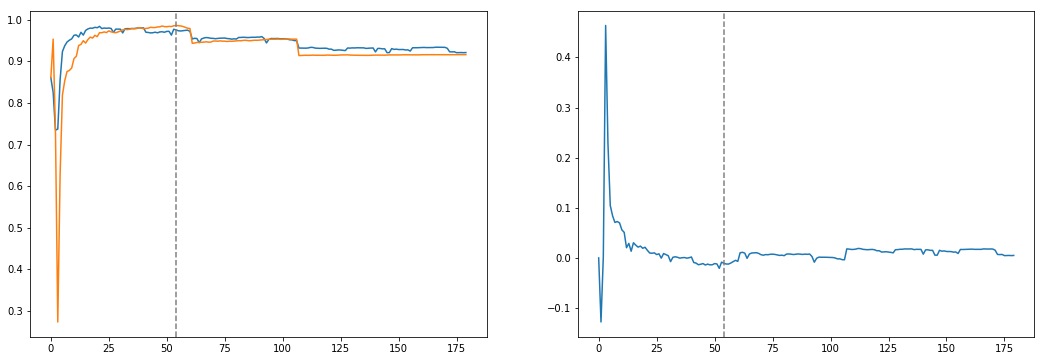

In [28]:
m = 25

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

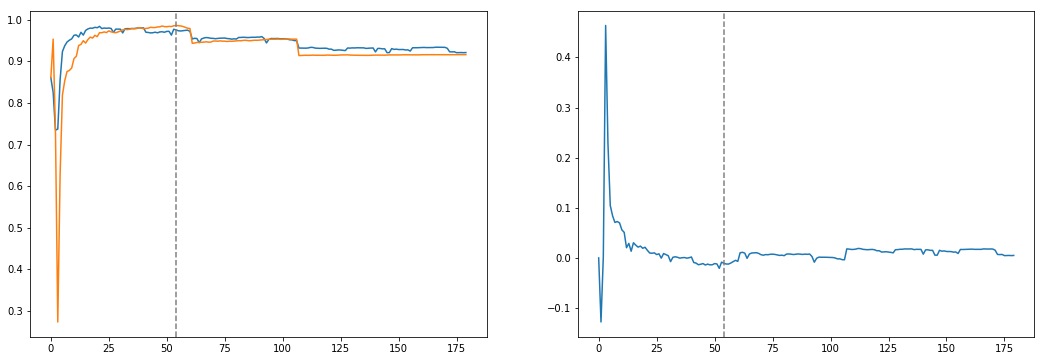

In [29]:
m = 50

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

---

In [30]:
all_diff = []
for m in range(1, m_):
    features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10
    
    diff = (net(Variable(torch.FloatTensor(vif))).data.numpy()[m_] - true_results[i][:, -1][m_])
    all_diff.append(diff)

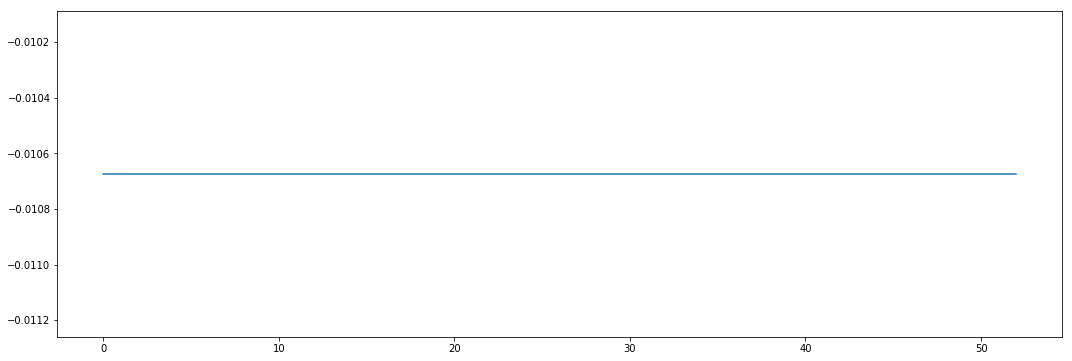

In [31]:
fig = plt.figure(figsize=(18,6))

plt.plot(all_diff)

---

Dataset number 3:

In [32]:
i = 3

In [33]:
m_ = true_results[i][:, -1].argmax()

In [34]:
m_

16

Let's consider $m^* == 16$

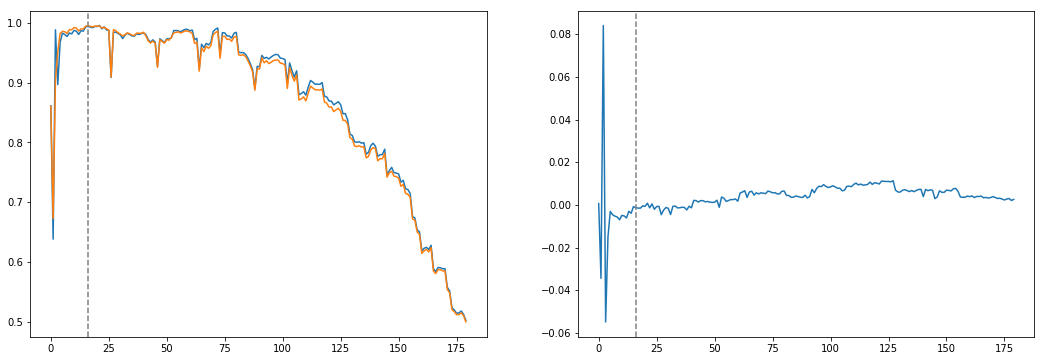

In [35]:
m = 5

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

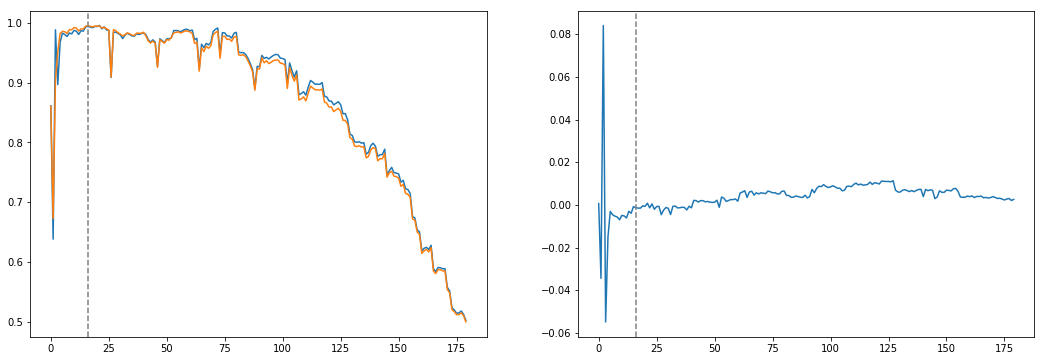

In [36]:
m = 10

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

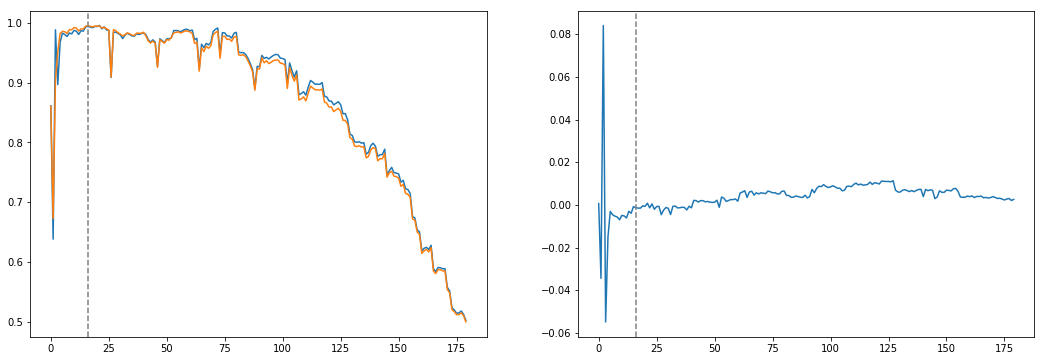

In [37]:
m = 15

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

---

In [38]:
all_diff = []
for m in range(1, m_):
    features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10
    
    diff = (net(Variable(torch.FloatTensor(vif))).data.numpy()[m_] - true_results[i][:, -1][m_])
    all_diff.append(diff)

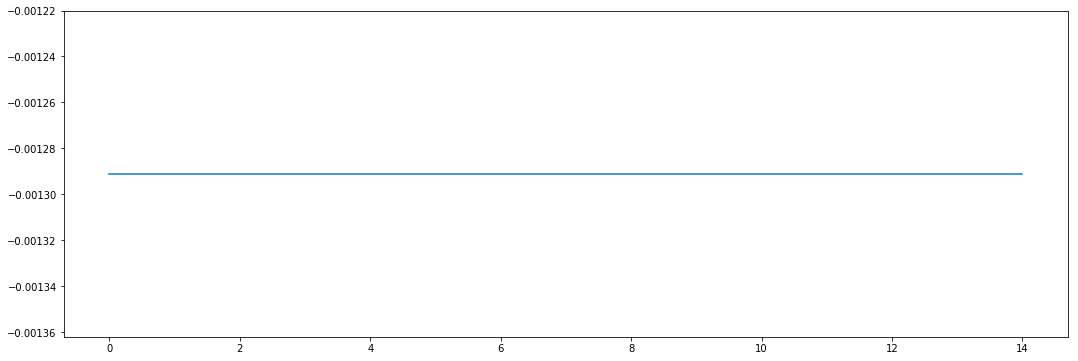

In [39]:
fig = plt.figure(figsize=(18,6))

plt.plot(all_diff)

Dataset number 2:

In [59]:
i = 2

In [60]:
m_ = true_results[i][:, -1].argmax()

In [61]:
m_

176

Let's consider $m^* == 176$

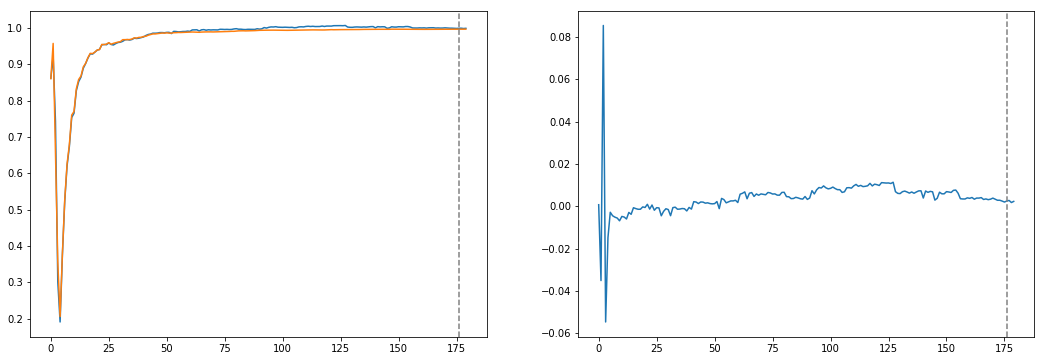

In [62]:
m = 10

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

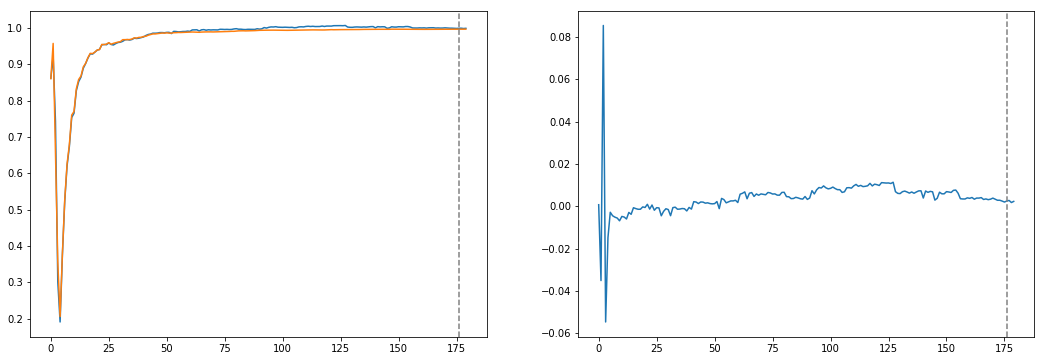

In [63]:
m = 50

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

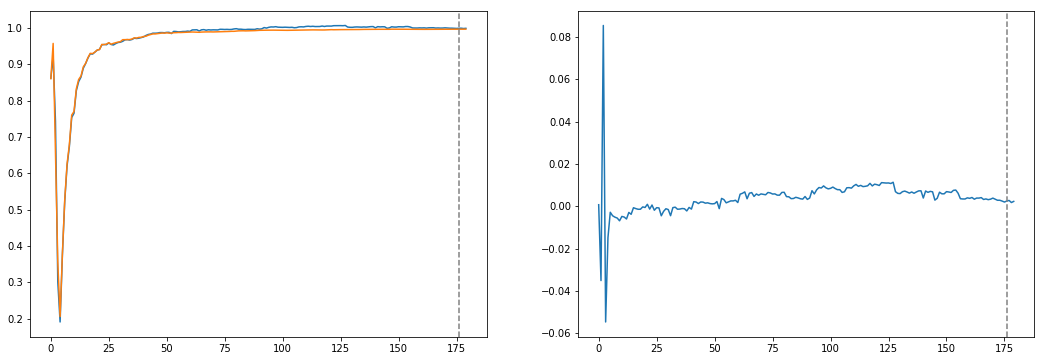

In [64]:
m = 100

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

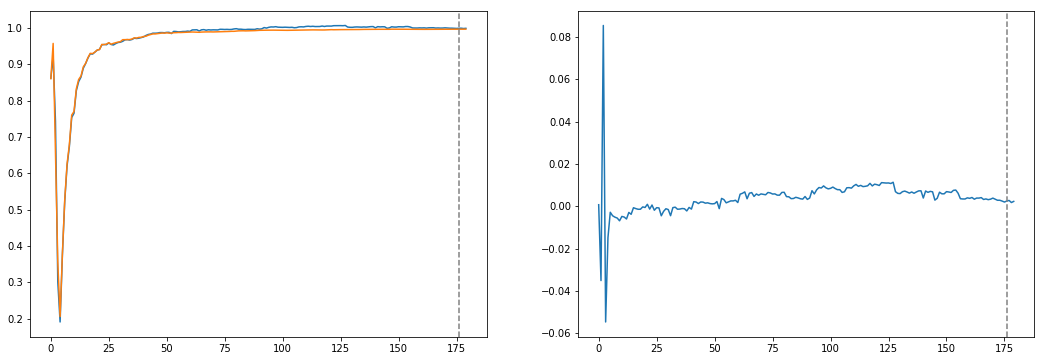

In [65]:
m = 150

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

---

In [66]:
all_diff = []
for m in range(1, m_):
    features = "+".join(map(str, datasets[i].iloc[:m,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10
    
    diff = (net(Variable(torch.FloatTensor(vif))).data.numpy()[m_] - true_results[i][:, -1][m_])
    all_diff.append(diff)

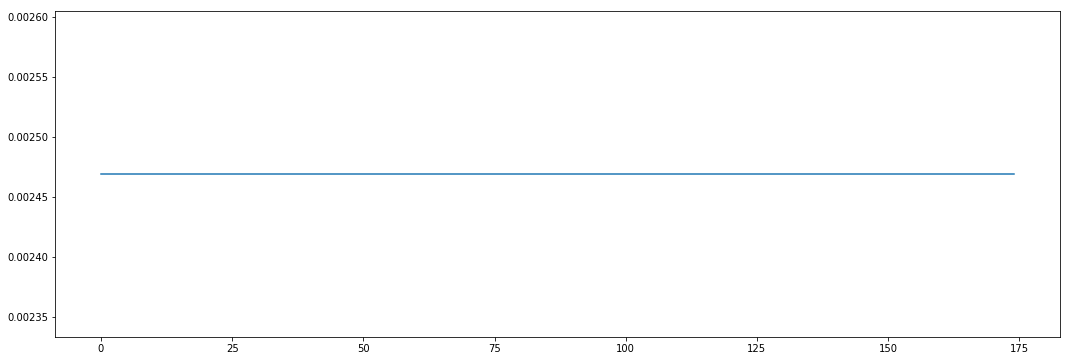

In [67]:
fig = plt.figure(figsize=(18,6))

plt.plot(all_diff)

### Interpolation

In [40]:
from scipy.signal import savgol_filter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122755d30>,
      dtype=object)

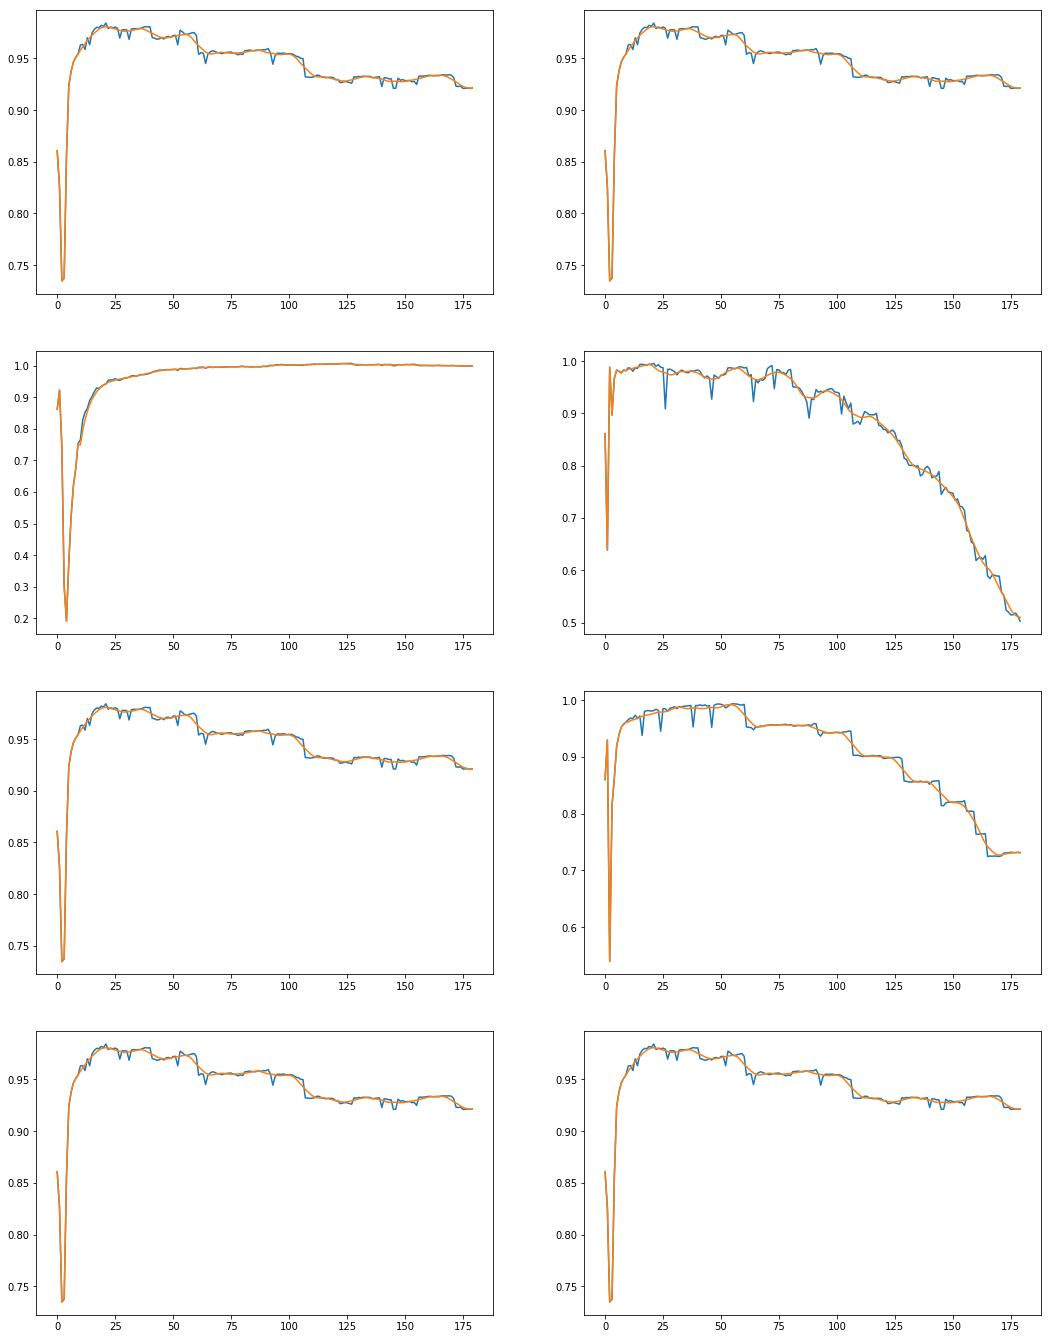

In [75]:
fig, axes = plt.subplots(4, 2, figsize=(18,24))

for i in range(len(datasets)):
    features = "+".join(map(str, datasets[i].iloc[:,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10

    x = net(Variable(torch.FloatTensor(vif))).data.numpy()
    axes[i//2, i%2].plot(x)
    y = savgol_filter(x, 7, 3, mode='nearest')
    y = savgol_filter(y, 9, 1, mode='nearest')
    axes[i//2, i%2].plot(np.hstack((x[:10],y[10:])))
    #axes[i//2, i%2].plot(true_results[i][:, -1])

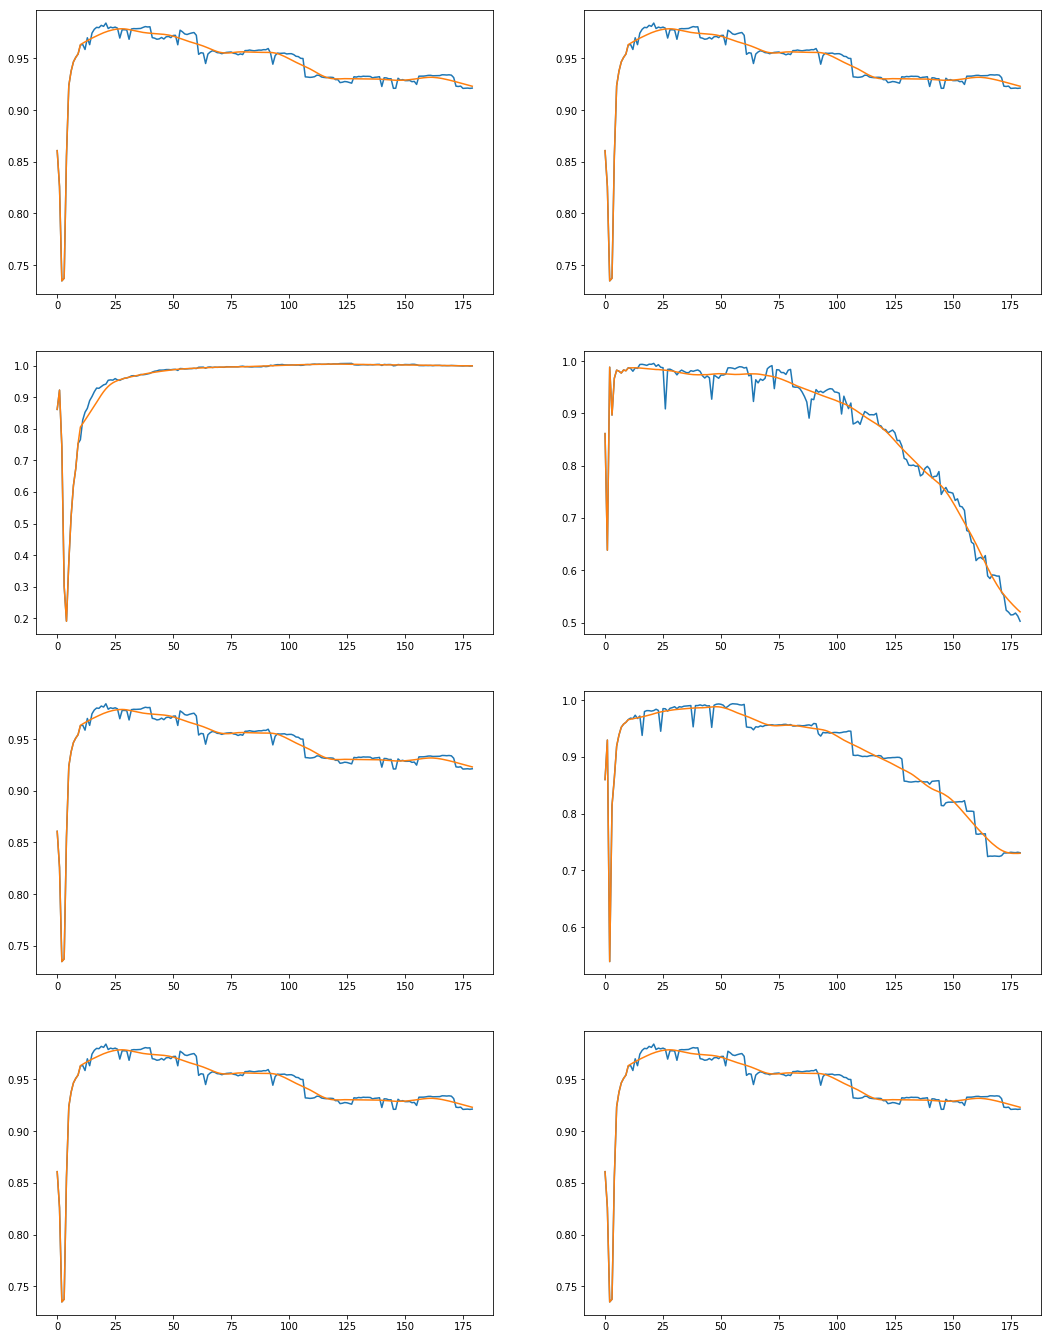

In [95]:
fig, axes = plt.subplots(4, 2, figsize=(18,24))

for i in range(len(datasets)):
    features = "+".join(map(str, datasets[i].iloc[:,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10

    x = net(Variable(torch.FloatTensor(vif))).data.numpy()
    axes[i//2, i%2].plot(x)
    y = savgol_filter(x[8:], 15, 3, mode='nearest')
    y = savgol_filter(y, 21, 1, mode='nearest')
    axes[i//2, i%2].plot(np.hstack((x[:10],y[2:])))
    #axes[i//2, i%2].plot(true_results[i][:, -1])

---

In [81]:
import scipy.interpolate as si

In [82]:
def bspline(cv, n=100, degree=3, periodic=False):
    """ Calculate n samples on a bspline

        cv :      Array ov control vertices
        n  :      Number of samples to return
        degree:   Curve degree
        periodic: True - Curve is closed
                  False - Curve is open
    """
    # If periodic, extend the point array by count+degree+1
    cv = np.asarray(cv)
    count = len(cv)

    if periodic:
        factor, fraction = divmod(count+degree+1, count)
        cv = np.concatenate((cv,) * factor + (cv[:fraction],))
        count = len(cv)
        degree = np.clip(degree,1,degree)

    # If opened, prevent degree from exceeding count-1
    else:
        degree = np.clip(degree,1,count-1)

    # Calculate knot vector
    kv = None
    if periodic:
        kv = np.arange(0-degree,count+degree+degree-1,dtype='int')
    else:
        kv = np.concatenate(([0]*degree, np.arange(count-degree+1), [count-degree]*degree))

    # Calculate query range
    u = np.linspace(periodic,(count-degree),n)

    # Calculate result
    return np.array(si.splev(u, (kv,cv.T,degree))).T

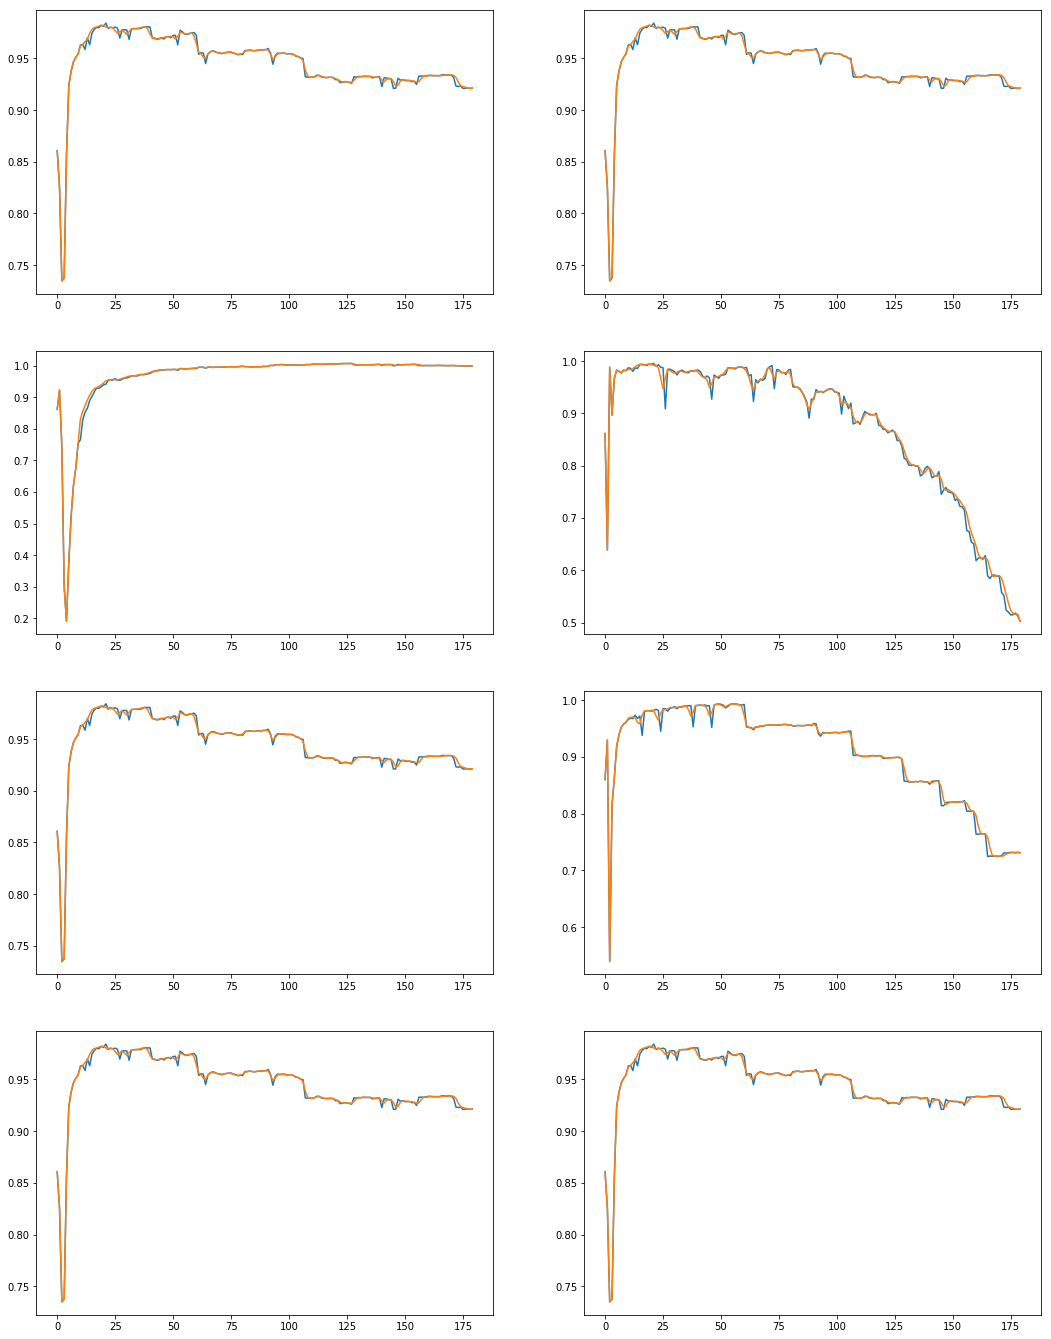

In [96]:
fig, axes = plt.subplots(4, 2, figsize=(18,24))

for i in range(len(datasets)):
    features = "+".join(map(str, datasets[i].iloc[:,:-1].columns))
    y, X = dmatrices('v ~' + features, datasets[i], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10

    x = net(Variable(torch.FloatTensor(vif))).data.numpy()
    axes[i//2, i%2].plot(x)
    y = bspline(x, len(x))
    y = bspline(y, len(x), degree=2)
    y = bspline(y, len(x), degree=1)
    axes[i//2, i%2].plot(np.hstack((x[:10],y[10:])))
    #axes[i//2, i%2].plot(true_results[i][:, -1])

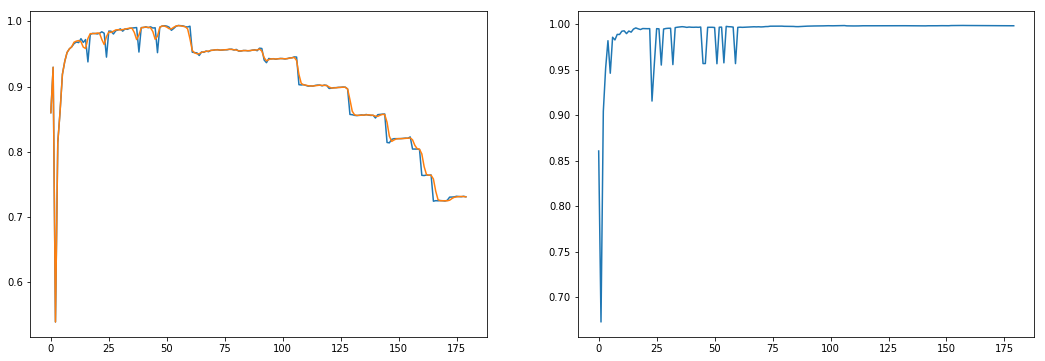

In [99]:
fig=plt.figure(figsize=(18,6))
i = 0

features = "+".join(map(str, verify_datasets[i].iloc[:,:-1].columns))
y, X = dmatrices('v ~' + features, verify_datasets[i], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, k) for k in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
x = net(Variable(torch.FloatTensor(vif))).data.numpy()
ax.plot(x)
y = bspline(x, len(x))
y = bspline(y, len(x), degree=2)
y = bspline(y, len(x), degree=1)
ax.plot(np.hstack((x[:10],y[10:])))

ax = fig.add_subplot(122)
ax.plot(verify_results[i][:, -1])